In [58]:
'''
File name: Project.ipynb
Date created: 01/11/2022
Date last modified: 15/11/2022
Python Version: 3.9.13
'''

'\nFile name: Project.ipynb\nDate created: 01/11/2022\nDate last modified: 15/11/2022\nPython Version: 3.9.13\n'

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations  #used to create unique pairs from a list
import numpy as np
import plotly.express as px  #for plots with integrated cursor for better visualization
from pandas_profiling import ProfileReport

DATA_FOLDER = 'MovieSummaries/'

In [60]:
#Create dataframes from the orignal dataset 
moviedata = pd.read_csv(DATA_FOLDER + 'movie.metadata.tsv', sep = '\t', index_col='wiki_id' , header=None, names=('wiki_id','freebase_id','movie_name','release','revenue','runtime','languages','countries','genres'))
charadata = pd.read_csv(DATA_FOLDER + 'character.metadata.tsv', sep = '\t', header=None, names=('wiki_id','freebase_id','release','character_name','actor_dob','actor_gender','actor_height','actor_ethnicity','actor_name','actor_age','freebase_chara_map1','freebase_chara_map2','freebase_chara_map3'))
plots =  pd.read_csv(DATA_FOLDER + 'plot_summaries.txt', sep = '\t', header=None, names=('wiki_id','plot'))

In [61]:
#Set the commom index present in all datasets as wiki_id
charadata.set_index('wiki_id',inplace=True)
plots.set_index('wiki_id',inplace=True)

### Data Exploration

In [62]:
#Filter the three datasets to obtain only movies which have a list of characters and a plot summary
indexes = moviedata.index.intersection(charadata.index)
indexes = plots.index.intersection(indexes)

#Create new filtered dataset using indexes of movies common to the three datasets
moviedata_intersect = moviedata.loc[indexes]
charadata_intersect = charadata.loc[indexes]
plots_intersect = plots.loc[indexes]

In [63]:
print('We had originally the plot summaries of {} movies. After the intersect, we get a total of {} movies from which we have the characters and the plot summaries. Proportion filtered out : {:.2%}.\n'.format(len(plots),len(plots_intersect),1-(len(plots_intersect)/len(plots))))
print('The movie metadata contained originally {} movies. After filtering the dataset, we get {} movies. Proportion filtered out : {:.2%}.\n'.format(len(moviedata),len(moviedata_intersect),1-(len(moviedata_intersect)/len(moviedata))))
print('The character metadata contained originally {} characters. After filtering the dataset, we get {} characters. Proportion filtered out : {:.2%}.'.format(len(charadata),len(charadata_intersect),1-(len(charadata_intersect)/len(charadata))))

We had originally the plot summaries of 42303 movies. After the intersect, we get a total of 37779 movies from which we have the characters and the plot summaries. Proportion filtered out : 10.69%.

The movie metadata contained originally 81741 movies. After filtering the dataset, we get 37779 movies. Proportion filtered out : 53.78%.

The character metadata contained originally 450669 characters. After filtering the dataset, we get 308485 characters. Proportion filtered out : 31.55%.


#### Analysis resultig from profiling : 

Movies dataset :

- 80% of missing values in revenue : we cannot use this feature.

- Outliers within runtime :  *We are not going to use this feature*

 Character dataset :  
 
- Unknowed gender : *These actors play unnamed character in 80% of the cases, we could avoid using them when running some analysis*

- Outlier in actor age : *225 values <0 probably dur to mistakes, we take these values out to observe distribution*

- Ethnicity : Hard to use, 75% of missing values

- Height : 60% of missing values and outliers, anyway useless feature in our case

In [64]:
moviedata_intersect.describe()

,revenue,runtime
count,7.496000e+03,3.257000e+04
mean,5.226429e+07,1.337374e+02
std,1.172850e+08,5.979946e+03
min,1.020000e+04,5.666667e-01
25%,2.543856e+06,8.800000e+01
50%,1.272980e+07,9.700000e+01
75%,4.630821e+07,1.110000e+02
max,2.782275e+09,1.079281e+06


Code to observe these statements : 

In [65]:
#Look at outliers in movies runtime
print(moviedata_intersect['runtime'][moviedata_intersect['runtime']>400].head(10))
print("Number of movies with excessive runtime :", moviedata_intersect['runtime'][moviedata_intersect['runtime']>400].shape[0])
print("As we won't use this feature, these outliers are not important.")

wiki_id
25930191       1560.00
147213          544.00
2792417         401.00
1060418         417.00
19653659        700.00
24871531        599.00
10815585    1079281.00
36136594       4875.27
24873771       1440.00
11829180       1200.00
Name: runtime, dtype: float64
Number of movies with excessive runtime : 20
As we won't use this feature, these outliers are not important.


In [66]:
#Look at missing values in actor_gender
print ("Proportion of character without name among actors whose gender is unknown : {0:.2%}".format(charadata_intersect['character_name'][charadata_intersect['actor_gender'].isna()].isna().sum()/len(charadata_intersect['character_name'][charadata_intersect['actor_gender'].isna()])))

Proportion of character without name among actors whose gender is unknown : 81.81%


As we can see, most of non specificied genders arise from unnamed characters, which probably means that these characters are negligable. Thus, we won't take these characters into acount when running analysis on genders.

In [67]:
#Look at outliers in actor age
print("Number of errors in actors age :",len(charadata_intersect[charadata_intersect['actor_age']<0]))
charadata_intersect[charadata_intersect['actor_age']<0].head()

Number of errors in actors age : 225


,freebase_id,release,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_chara_map1,freebase_chara_map2,freebase_chara_map3
wiki_id,,,,,,,,,,,,
22829,/m/05q8n,1965-06-01,The Black Ghoul,1978-07-18,F,NaN,/m/03ts0c,Cheyenne Silver,-13.0,/m/0cbwtz8,/m/0cbwtzc,/m/06616j
4210812,/m/0bq4vz,1910-03-24,Glinda,1992-02-17,M,NaN,NaN,Olive Cox,-81.0,/m/09z696c,/m/022qn6,/m/09z696h
5626726,/m/0dx12p,1936-02-14,NaN,1944-12-09,M,NaN,NaN,Bob O'Connor,-8.0,/m/0k4k1m,NaN,/m/064_gh
7735007,/m/0kvg60,1966,NaN,1996-08-14,M,NaN,NaN,Jack Fletcher,-30.0,/m/0gcmsrc,NaN,/m/07p1ck
6667989,/m/0ggp41,1960-09-22,Khalillah,1989-05-05,F,1.6,NaN,Larissa Wilson,-28.0,/m/063lmhz,/m/063lmj0,/m/02pv8ss


We can see that these impossible values come from mistakes in the actor date of birth, so we won't correcti it for only 225 caracters.

In [68]:
moviedata_intersect.head()

,freebase_id,movie_name,release,revenue,runtime,languages,countries,genres
wiki_id,,,,,,,,
23890098,/m/076w2lb,Taxi Blues,1990-09-07,NaN,110.0,"{""/m/06b_j"": ""Russian Language""}","{""/m/0f8l9c"": ""France"", ""/m/05vz3zq"": ""Soviet ...","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci..."
31186339,/m/0gkz15s,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."
20663735,/m/051zjwb,Narasimham,2000,NaN,175.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""..."
2231378,/m/06xtz3,The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""..."
595909,/m/02tqm5,A Cry in the Dark,1988-11-03,6908797.0,121.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


In [69]:
plots_intersect.head()

,plot
wiki_id,
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...


#### Filtering and segmentation of data

Here we remove all columns that will not be useful for the further analysis. In addition, we remove all characters with missing values in release date and/or gender as we want to study women's representation over time. Finally, we create a column which correspond to the decade in which the movie was released. Grouping movies by decade allows a fine temporal evolution with an increased amount of data to perform the analysis. We devide the dataset by decade as it seems to us that in such a period, the lifestyle remains constant. Indeed, we can asumme that the purchasing power, population, movie habits and genre popularity remained stable.   

In [70]:
#For each character, drop columns which have no use for our analysis and add column for decade distinction
charadata_filtered = charadata_intersect.drop(['freebase_id','actor_dob', 'actor_height', 'actor_ethnicity', 'freebase_chara_map1','freebase_chara_map2','freebase_chara_map3'], axis = 1)
charadata_filtered['release'] = pd.to_datetime(charadata_filtered['release'], errors = 'coerce')
charadata_filtered['release'] = pd.DatetimeIndex(charadata_filtered['release']).year
charadata_filtered = charadata_filtered[charadata_filtered['release'].notna()]
charadata_filtered['release'] = charadata_filtered['release'].astype(int)
charadata_filtered['decade'] = (charadata_filtered['release']//10)*10


charadata_filtered = charadata_filtered[charadata_filtered['actor_gender'].notna()] #drop characters who do not have a gender
charadata_filtered = charadata_filtered[charadata_filtered['actor_age']>=0] #remove characters with odd ages values

#For each movie, drop columns which have no use for our analysis indicate its decade of release and the year in the decade (ie. 0,1,2,3,4,5,6,7,8,9)
moviedata_filtered = moviedata_intersect.drop(['freebase_id','revenue','runtime','languages'], axis = 1)
moviedata_filtered['release'] = pd.to_datetime(moviedata_filtered['release'], errors = 'coerce')
moviedata_filtered['release'] = pd.DatetimeIndex(moviedata_filtered['release']).year
moviedata_filtered = moviedata_filtered[moviedata_filtered['release'].notna()]
moviedata_filtered['release'] = moviedata_filtered['release'].astype(int)
moviedata_filtered['decade'] = (moviedata_filtered['release']//10)*10
moviedata_filtered['year'] = moviedata_filtered['release']%10

#Remove the genre ID (e.g. /m/07s9rl0)to get only the string of the genres to allow analysis
moviedata_filtered['genres'] = moviedata_filtered['genres'].apply(lambda x : x.replace(':', ','))
moviedata_filtered['genres'] = moviedata_filtered['genres'].apply(eval)
moviedata_filtered['genres'] = moviedata_filtered['genres'].apply(lambda x: list(x))
moviedata_filtered['genres'] = moviedata_filtered['genres'].apply(lambda y: list(filter(lambda x: not x.startswith('/m'), y)))
#do the same for the countries names
moviedata_filtered['countries'] = moviedata_filtered['countries'].apply(lambda x : x.replace(':', ','))
moviedata_filtered['countries'] = moviedata_filtered['countries'].apply(eval)
moviedata_filtered['countries'] = moviedata_filtered['countries'].apply(lambda x: list(x))
moviedata_filtered['countries'] = moviedata_filtered['countries'].apply(lambda y: list(filter(lambda x: not x.startswith('/m'), y)))

#Keep only the overlap of the three datasets to obtain only movies which have a list of characters and a plot summary after the filter
indexes_filtered = moviedata_filtered.index.intersection(charadata_filtered.index)
indexes_filtered = plots.index.intersection(indexes_filtered)

moviedata_filtered = moviedata_filtered.loc[indexes_filtered]
charadata_filtered = charadata_filtered.loc[indexes_filtered]
plots_filtered = plots_intersect.loc[indexes_filtered]

In [71]:
moviedata_filtered.head()

,movie_name,release,countries,genres,decade,year
wiki_id,,,,,,
23890098,Taxi Blues,1990,"[France, Russia, Soviet Union]","[World cinema, Drama]",1990,0
31186339,The Hunger Games,2012,[United States of America],"[Action/Adventure, Action, Drama, Science Fict...",2010,2
20663735,Narasimham,2000,[India],"[Action, Musical, Drama, Bollywood]",2000,0
2231378,The Lemon Drop Kid,1951,[United States of America],"[Comedy, Screwball comedy]",1950,1
595909,A Cry in the Dark,1988,"[United States of America, Australia, New Zeal...","[Docudrama, Crime Fiction, Courtroom Drama, Wo...",1980,8


In [72]:
#We look at the missing information for the remainings movies in the movie metadata
moviedata_filtered.isna().sum()

movie_name    0
release       0
countries     0
genres        0
decade        0
year          0
dtype: int64

#### Visualization

In [73]:
#Assess women's presence accross all charaters from every movies
M_count = charadata_filtered[charadata_filtered.actor_gender == 'M'].shape[0]
F_count = charadata_filtered[charadata_filtered.actor_gender == 'F'].shape[0]
defined_gender_count = charadata_filtered.shape[0]

M_proportion = M_count / defined_gender_count
F_proportion = F_count / defined_gender_count

print(M_count, F_count, M_proportion, F_proportion)

139691 71526 0.6613624850272468 0.33863751497275313


# PRINT

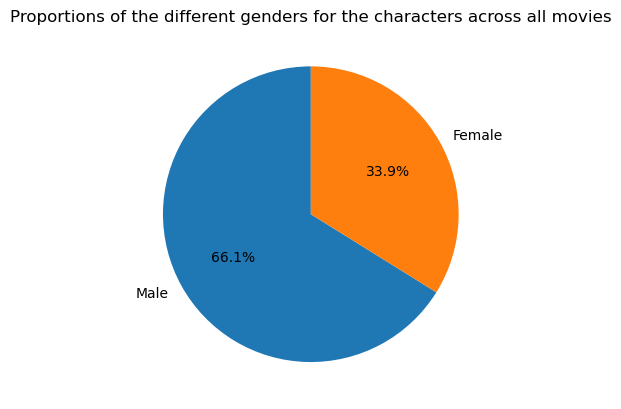

In [74]:
plt.pie([M_proportion, F_proportion], labels = ["Male", "Female"], startangle = 90, autopct = "%0.1f%%")
plt.title("Proportions of the different genders for the characters across all movies")
plt.show()

In [75]:
#Assess average women's presence per movie 
gender_count_permovie = charadata_filtered.groupby('wiki_id').apply(lambda x : pd.Series({'nb_male' : x[x.actor_gender == 'M'].shape[0], 
                                                                                       'nb_female' : x[x.actor_gender == 'F'].shape[0]}))
                                                                                       
#Compute proportions of each gender per movie
gender_count_permovie['M_proportion'] = gender_count_permovie.nb_male / (gender_count_permovie.nb_male + gender_count_permovie.nb_female)
gender_count_permovie['F_proportion'] = gender_count_permovie.nb_female / (gender_count_permovie.nb_male + gender_count_permovie.nb_female)

gender_count_permovie.head()

,nb_male,nb_female,M_proportion,F_proportion
wiki_id,,,,
330,0,4,0.000000,1.000000
3217,9,3,0.750000,0.250000
3333,0,1,0.000000,1.000000
3746,10,3,0.769231,0.230769
3837,18,2,0.900000,0.100000


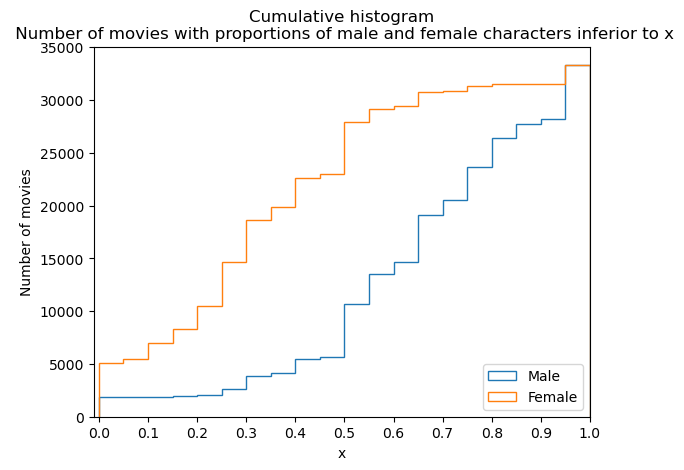

In [76]:
plt.hist(gender_count_permovie.M_proportion, bins = 20, cumulative = True, histtype = 'step',label='Male')
plt.hist(gender_count_permovie.F_proportion, bins = 20, cumulative = True, histtype = 'step',label='Female')
plt.xlim(-0.01,1)
plt.xticks(np.arange(0,1.1,0.1))
plt.title("Cumulative histogram\n Number of movies with proportions of male and female characters inferior to x")
plt.xlabel('x')
plt.ylabel('Number of movies')
plt.legend(loc='lower right')
plt.show()

# TEXTE EXPLICATIF RESULTAT GRAPHE AU DESSUS

In [77]:
max_M = 0
max_F = 0
equal_MF = 0
for i in range(gender_count_permovie.shape[0]) :
    if (gender_count_permovie.iloc[i]['nb_male'] > gender_count_permovie.iloc[i]['nb_female']) :
        max_M += 1
    elif (gender_count_permovie.iloc[i]['nb_male'] < gender_count_permovie.iloc[i]['nb_female']) : 
        max_F += 1
    elif (gender_count_permovie.iloc[i]['nb_male'] == gender_count_permovie.iloc[i]['nb_female']) :
        equal_MF += 1

print(max_M,max_F,equal_MF)

23028 5692 4632


# PRINT

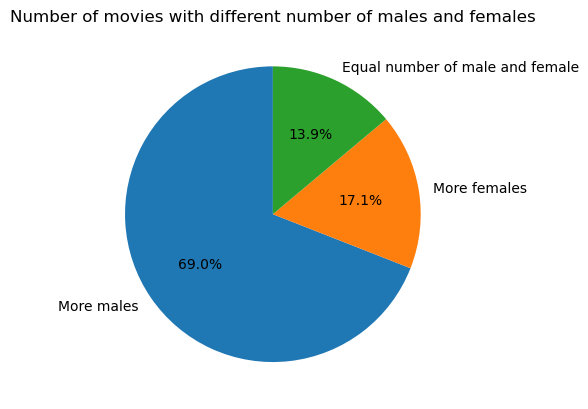

In [78]:
plt.pie([max_M,max_F,equal_MF], labels = ["More males", "More females", "Equal number of male and female"], startangle = 90, autopct = "%0.1f%%")
plt.title("Number of movies with different number of males and females")
plt.show()

In [79]:
charadata_filtered

,release,character_name,actor_gender,actor_name,actor_age,decade
wiki_id,,,,,,
23890098,1990,NaN,M,Pyotr Mamonov,39.0,1990
23890098,1990,NaN,M,Hal Singer,70.0,1990
31186339,2012,Katniss Everdeen,F,Jennifer Lawrence,21.0,2010
31186339,2012,Peeta Mellark,M,Josh Hutcherson,19.0,2010
31186339,2012,Effie Trinket,F,Elizabeth Banks,38.0,2010
...,...,...,...,...,...,...
6040782,1971,NaN,M,Arthur Lowe,55.0,1970
6040782,1971,NaN,M,John Le Mesurier,58.0,1970
6040782,1971,NaN,M,Clive Dunn,51.0,1970


Number of movies per actor/actress

In [80]:
movies_count_peractor = charadata_filtered.groupby('actor_name').apply(lambda x : pd.Series({'actor_gender' : x['actor_gender'].unique()[0], 
                                                                                       'num_movies' : x.index.nunique()}))
movies_count_peractor.head()

,actor_gender,num_movies
actor_name,,
'King Kong' Kashey,M,1
2 Tuff Tony,M,1
40 Glocc,M,1
50 Cent,M,15
A Martinez,M,8


# MANQUE EXPLICATION PK ON REGARDE çA 

In [81]:
mean_M = (movies_count_peractor[movies_count_peractor['actor_gender']=='M']['num_movies']).mean()
mean_F = (movies_count_peractor[movies_count_peractor['actor_gender']=='F']['num_movies']).mean()
median_M = (movies_count_peractor[movies_count_peractor['actor_gender']=='M']['num_movies']).median()
median_F = (movies_count_peractor[movies_count_peractor['actor_gender']=='F']['num_movies']).median()
std_M = (movies_count_peractor[movies_count_peractor['actor_gender']=='M']['num_movies']).std()
std_F = (movies_count_peractor[movies_count_peractor['actor_gender']=='F']['num_movies']).std()
print('Median number of movies per male actor =',median_M,'mean number of movies per male actor =',mean_M, 'std =',std_M)
print('Median number of movies per female actor =',median_F,'mean number of movies per female actor =',mean_F, 'std =',std_F)

Median number of movies per male actor = 2.0 mean number of movies per male actor = 5.40801064954387 std = 9.64303182027481
Median number of movies per female actor = 2.0 mean number of movies per female actor = 4.512440343620744 std = 6.576056233462031


# MANQUE EXPLICATION PK ON REGARDE çA 

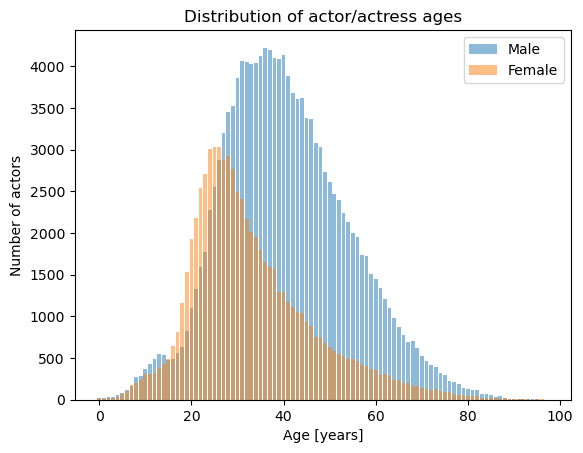

In [82]:
#Plot age distribution across gender

df_wo_ol = charadata_filtered[charadata_filtered['actor_age']>=0]
M = df_wo_ol[df_wo_ol['actor_gender']=='M']
F = df_wo_ol[df_wo_ol['actor_gender']=='F']
Mc = M['actor_age'].value_counts()
Fc = F['actor_age'].value_counts()

plt.bar(np.sort(Mc.index),Mc[np.sort(Mc.index)],alpha=0.5,label='Male')
plt.bar(np.sort(Fc.index),Fc[np.sort(Fc.index)],alpha=0.5,label='Female')
plt.title("Distribution of actor/actress ages")
plt.xlabel('Age [years]')
plt.ylabel('Number of actors')
plt.legend(loc='upper right')
plt.show()

Analysis across time

<AxesSubplot:xlabel='decade'>

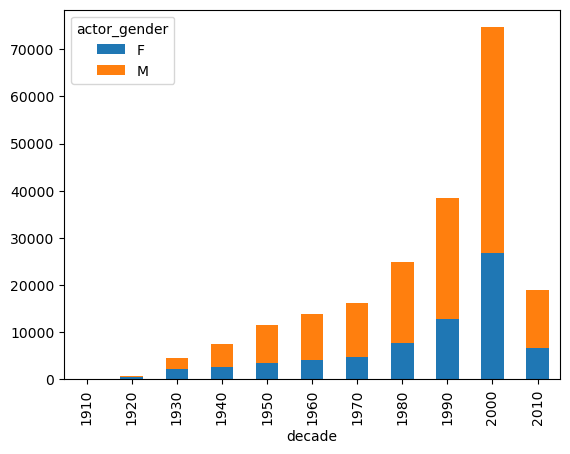

In [83]:
#Look at gender distribution along time

charadata_filtered.groupby(['decade', 'actor_gender'])['actor_gender'].count().unstack().plot.bar(stacked=True)

# LABEL + LEGENDE 

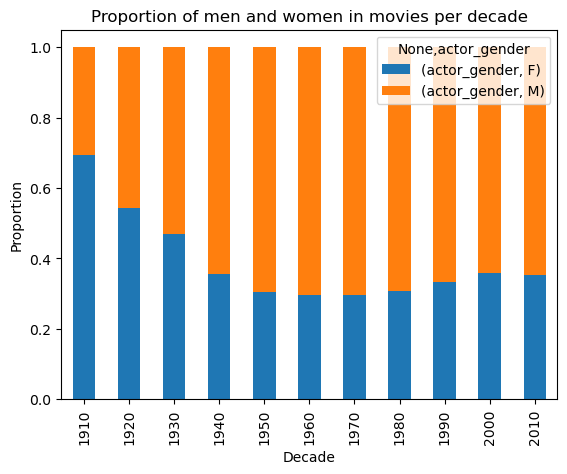

In [84]:
#Plot proportion of genders across time
pd.DataFrame(
    charadata_filtered.groupby(
        ['decade', 'actor_gender'])['actor_gender'].count()/np.repeat(charadata_filtered.groupby(['decade']).size().values, 2)
        ).unstack().plot.bar(stacked=True,title='Proportion of men and women in movies per decade', xlabel='Decade',ylabel='Proportion')

plt.show()

# PBLM AVEC LEGENDE

In [85]:
#Count male and female characters per decade across all movies
gender_count_perdecade = charadata_filtered.groupby('decade').apply(lambda x : pd.Series({'M' : x[x.actor_gender == 'M'].shape[0], 
                                                                                       'F' : x[x.actor_gender == 'F'].shape[0]}))
gender_count_perdecade['F_M_Ratio'] = gender_count_perdecade.F / (gender_count_perdecade.M + gender_count_perdecade.F)

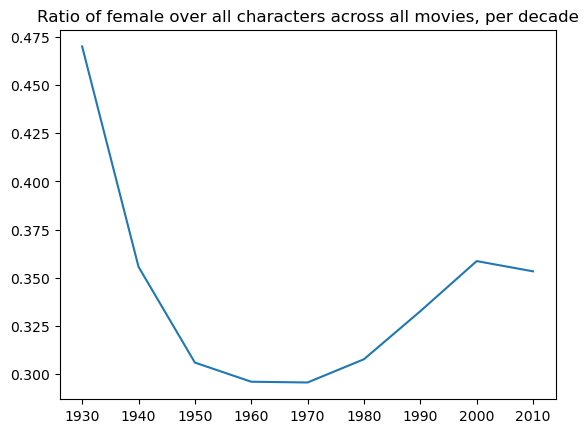

In [86]:
plt.plot(gender_count_perdecade.index[2:], gender_count_perdecade.F_M_Ratio[2:], ls = '-')
plt.title("Ratio of female over all characters across all movies, per decade")
plt.show()

# MANQUE LABEL

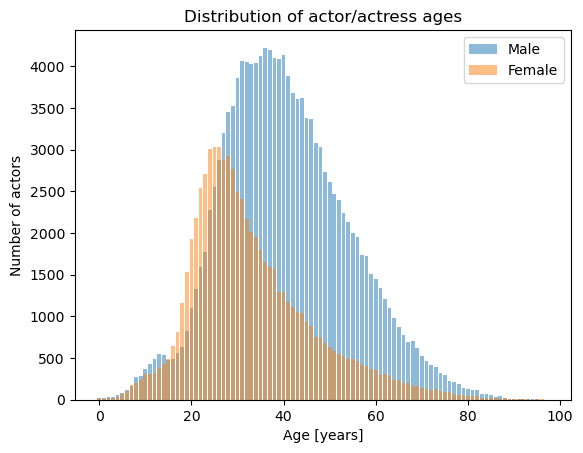

In [87]:
#Plot age distribution across gender

df_wo_ol = charadata_filtered[charadata_filtered['actor_age']>=0]
M = df_wo_ol[df_wo_ol['actor_gender']=='M']
F = df_wo_ol[df_wo_ol['actor_gender']=='F']
Mc = M['actor_age'].value_counts()
Fc = F['actor_age'].value_counts()

plt.bar(np.sort(Mc.index),Mc[np.sort(Mc.index)],alpha=0.5,label='Male')
plt.bar(np.sort(Fc.index),Fc[np.sort(Fc.index)],alpha=0.5,label='Female')
plt.title("Distribution of actor/actress ages")
plt.xlabel('Age [years]')
plt.ylabel('Number of actors')
plt.legend(loc='upper right')
plt.show()

# FAIRE ACROSS TIME

#### ANALYSIS BY GENRE

Following the observed trends and results previously obtained, we would like to know wether these apply to distinct genres within the film industry. Analysis accross genres allows to determine the most popular ones which implies a superior impact on the society. Repeating steps previously done such as age and proportion of male vs female characters over time for distinct genres would allow to highligths effects common to the whole industry. Due to the variety of genres in the dataset, it would be better to focus on a lesser extent of genres with a sufficient count for relevance and that are as distinct as possible to study similarity.

In [88]:
#input : takes a Series composed of lists of variavble sizes 
#output : a 1D Series with the lists placed end to end

def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

Text(0, 0.5, 'Count')

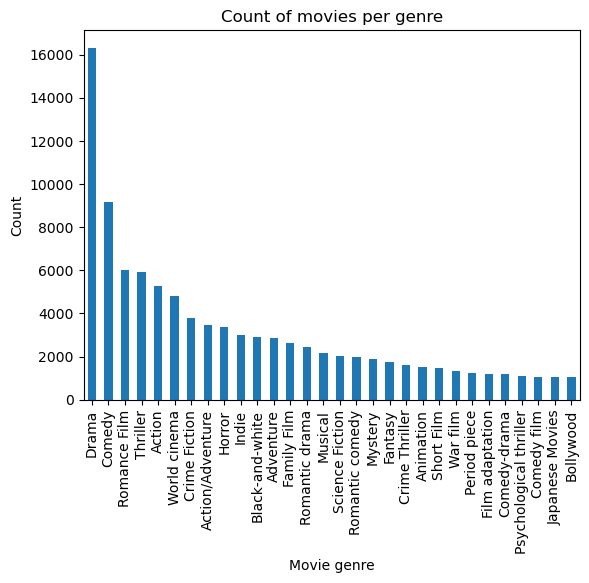

In [89]:
#counts the number of movies tagged with each genre 
#Plot the genres that contain more than a thousand movies
count_genres = to_1D(moviedata_filtered['genres']).value_counts()
count_genres = count_genres[count_genres>1000] 

count_genres.plot(kind='bar')
plt.title('Count of movies per genre')
plt.xlabel('Movie genre')
plt.ylabel('Count')

We decided to keep the top 10 genres with the highest movie counts to have a sufficient effect size for our following analysis. We notice that the genre World cinema is in the top 10. We decide to remove this genre as it represents all non-american movies while our dataset contains a majority of movies coming from the United States.

In [90]:
selected = count_genres[:10].index #we take the 10 genres with the highest counts of movies
selected = selected.drop(['World cinema']) 
identification_genre = moviedata_filtered[['genres']].copy() # temporary dataframe for genre identification for each movie

In [91]:
# for each genre checks if the movie is part of a top 10 genre
for i in selected:
    identification_genre[str(i)] = identification_genre['genres'].apply(lambda x: 1 if i in x else 0) # for each genre chekcs if the movie is part of the genre

From these top 10 genres, we want to find three genres that are independent and relevant in terms of effect size and unicity. This allows us to compare movies that belong to only one of the three different and independent genres to study if our following analysis shows the same results accross the film industry.

In [92]:
triplets = list((combinations(selected,3)))   # create all triplets possible for the selected genres
count_per_genre = np.zeros((len(triplets), 3))  # count number of movies for each genre for each triplet 
count_unique_per_genre = np.zeros((len(triplets), 3)) # count number of movies for each genre for each triplet which are not shared by the other genres of the triplet

for i, triplet in enumerate(triplets) :
    for j, genre in enumerate(triplet) :
        count_per_genre[i,j] = identification_genre.loc[:,genre].sum()  
        others = list(triplet)
        others.remove(genre)
        count_unique_per_genre[i,j] = len(identification_genre[(identification_genre[genre] == 1) \
            & (identification_genre[others[0]] != 1)\
            & (identification_genre[others[1]] != 1)])

In [93]:
#Criteria to select the genre triplet
loss_genres = (count_per_genre - count_unique_per_genre) / count_per_genre  
mean_loss = pd.Series(np.mean(loss_genres, axis=1), index = triplets) # mean per triplet of proportion of loss of number of shared movies    
genre_loss_std = pd.Series(np.std(loss_genres, axis=1), index = triplets) # std of loss of counts of movies in each triplet 
mean_count = pd.Series(np.mean(count_unique_per_genre, axis=1), index = triplets) # mean of counts of movies per triplet

In [94]:
evaluation_df = pd.concat([mean_loss,genre_loss_std,mean_count],axis=1)
evaluation_df.columns = ['mean count loss', 'std loss', 'mean counts']
fig = px.scatter(evaluation_df , x = 'mean count loss', y = 'std loss', color = 'mean counts', title="Scatter plot evaluating independence for genres in each triplet", width=716, height=750, hover_name = list(mean_count.index))
fig.show()

We can see that the triplet which looses few movie, in which the differences in count in the triplets is minimal and which has an overall high mean of counts of movies in the triplet is Romance Film, Action and Horror. 

In [95]:
#Check that each movie belongs to only one of the genres present in the triplet
selected_genres = ['Romance Film', 'Action', 'Horror']

for genre in selected_genres:
    moviedata_filtered[genre] = moviedata_filtered['genres'].apply(lambda x: 1 if genre in x else 0)

moviedata_filtered['unique_genre'] = moviedata_filtered.loc[:,selected_genres].sum(axis = 1)

In [96]:
#Drop movies that belong to more than one genre in the triplet or none of them
unique_genre = moviedata_filtered.drop(moviedata_filtered[moviedata_filtered['unique_genre'] != 1].index)

<AxesSubplot:>

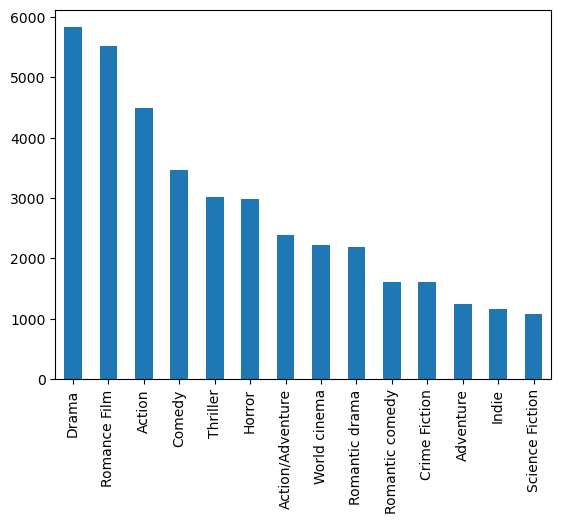

In [97]:
#Plot the distribution of count of movies that belong to one genre in the triplets
count_selected = to_1D(unique_genre['genres']).value_counts()

count_selected = count_selected[count_selected>1000]

count_selected.plot(kind='bar')

We notice that comedy and Drama have a high count of movies. This means that the movies filtered at this point from the dataset belong in adtion to one of the triplet genre to the Drama or Comedy. This higlights the fact that these genre are more general than others.

In [98]:
unique_genre.head()

,movie_name,release,countries,genres,decade,year,Romance Film,Action,Horror,unique_genre
wiki_id,,,,,,,,,,
31186339,The Hunger Games,2012,[United States of America],"[Action/Adventure, Action, Drama, Science Fict...",2010,2,0,1,0,1
20663735,Narasimham,2000,[India],"[Action, Musical, Drama, Bollywood]",2000,0,0,1,0,1
5272176,End Game,2006,"[United States of America, Germany, Canada]","[Thriller, Action/Adventure, Action, Drama]",2000,6,0,1,0,1
1952976,Dark Water,2005,[United States of America],"[Drama, Thriller, Horror]",2000,5,0,0,1,1
2462689,Meet John Doe,1941,[United States of America],"[Romantic comedy, Black-and-white, Media Satir...",1940,1,1,0,0,1


In [99]:
#Select the genre of the triplet to which the movie belongs
for genre in selected_genres:
    unique_genre['genres'] = unique_genre['genres'].apply(lambda x: genre if genre in x else x)

In [100]:
unique_genre.head()

,movie_name,release,countries,genres,decade,year,Romance Film,Action,Horror,unique_genre
wiki_id,,,,,,,,,,
31186339,The Hunger Games,2012,[United States of America],Action,2010,2,0,1,0,1
20663735,Narasimham,2000,[India],Action,2000,0,0,1,0,1
5272176,End Game,2006,"[United States of America, Germany, Canada]",Action,2000,6,0,1,0,1
1952976,Dark Water,2005,[United States of America],Horror,2000,5,0,0,1,1
2462689,Meet John Doe,1941,[United States of America],Romance Film,1940,1,1,0,0,1


In [101]:
print('Looking at these three specific genres we can study the evolution of women represention in {} movies'.format(len(unique_genre)))

Looking at these three specific genres we can study the evolution of women represention in 13007 movies


In [102]:
unique_genre.head()

,movie_name,release,countries,genres,decade,year,Romance Film,Action,Horror,unique_genre
wiki_id,,,,,,,,,,
31186339,The Hunger Games,2012,[United States of America],Action,2010,2,0,1,0,1
20663735,Narasimham,2000,[India],Action,2000,0,0,1,0,1
5272176,End Game,2006,"[United States of America, Germany, Canada]",Action,2000,6,0,1,0,1
1952976,Dark Water,2005,[United States of America],Horror,2000,5,0,0,1,1
2462689,Meet John Doe,1941,[United States of America],Romance Film,1940,1,1,0,0,1


In [103]:
print('We have a total of {} movies which allow the analysis over time'.format(len(unique_genre)))

We have a total of 13007 movies which allow the analysis over time


In [104]:
#Split the previous dataframe in three distinct ones for each genre to allow parallel analysis
horror = unique_genre.loc[unique_genre['genres'] == 'Horror'].copy()
action = unique_genre.loc[unique_genre['genres'] == 'Action'].copy()
romance = unique_genre.loc[unique_genre['genres'] == 'Romance Film'].copy()

In [105]:
#counts the amount of revenues provided in each genre
horror_count = len(horror.index)
action_count = len(action.index)
romance_count = len(romance.index)
print('We have now {} horror movies extracted.'.format(horror_count))
print('We have now {} horror movies extracted.'.format(action_count))
print('We have now {} horror movies extracted.'.format(romance_count))

We have now 2987 horror movies extracted.
We have now 4499 horror movies extracted.
We have now 5521 horror movies extracted.


Once more, we notice that a high amount of revenues were not indicated.

Now we will look at the evolution of the number of movies per decade for each of the three genres selected. We remove movies released after 2009 as we do not have the data for the complete 2010s decade. We also remove all movies released before the first year in which all three genres at a movie released so that we have a common timescale that can be compaed among the three genres.

In [131]:
#Find the first common year of release of a movie
min_shared_decade = max(min(horror['decade'].sort_values().unique()), min(romance['decade'].sort_values().unique()), min(action['decade'].sort_values().unique()))

#Drop all movies Before the minimal year and after 2009 
horror = horror.loc[(horror['decade'] >= min_shared_decade) & (horror['decade'] < 2010)].copy()
action = action.loc[(action['decade'] >= min_shared_decade) & (action['decade'] < 2010)].copy()
romance = romance.loc[(romance['decade'] >= min_shared_decade) & (romance['decade'] < 2010)].copy()

#Check number of characters per gender per decade for each genre
count_movies_genres = pd.DataFrame({'horror_nb_women' : horror.groupby('decade')['nb_women'].sum(),
                                    'horror_nb_men' : horror.groupby('decade')['nb_men'].sum(),
                                    'action_nb_women' : action.groupby('decade')['nb_women'].sum(),
                                    'action_nb_men' : action.groupby('decade')['nb_men'].sum(),
                                    'romance_nb_women' : romance.groupby('decade')['nb_women'].sum(),
                                    'romance_nb_men' : romance.groupby('decade')['nb_men'].sum(),
                                    })
count_movies_genres

,horror_nb_women,horror_nb_men,action_nb_women,action_nb_men,romance_nb_women,romance_nb_men
decade,,,,,,
1920,14,3,10,6,82,43
1930,76,65,125,290,527,411
1940,99,135,168,570,610,764
1950,129,380,263,1119,833,1235
1960,305,651,408,1569,939,1430
1970,735,1299,642,2518,782,1244
1980,928,1739,1087,3810,1442,2393
1990,888,1584,1688,5002,2930,4386
2000,2548,3990,3033,8403,6682,8972


We can see that the decade 1910 contains too few values for the gender analysis. We can remove it.

In [130]:
horror = horror.loc[horror['decade'] > 1910].copy()
action = action.loc[action['decade'] > 1910].copy()
romance = romance.loc[romance['decade'] > 1910].copy()

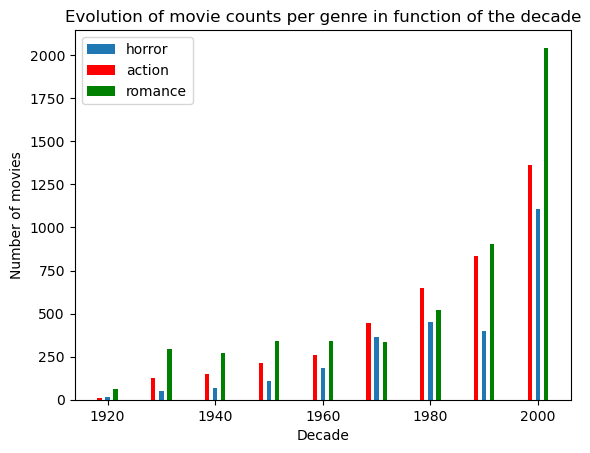

In [132]:
#Plot the evolution of the movie count per genre and per decade 
plt.bar(horror['decade'].sort_values().unique(), horror.groupby(['decade'])['release'].count(), label = 'horror')
plt.bar(action['decade'].sort_values().unique() - 1.5, action.groupby(['decade'])['release'].count(), color='red', label = 'action')
plt.bar(romance['decade'].sort_values().unique() + 1.5, romance.groupby(['decade'])['release'].count(), color= 'green', label = 'romance')

plt.legend(loc = 'upper left')
plt.title('Evolution of movie counts per genre in function of the decade')
plt.xlabel('Decade')
plt.ylabel('Number of movies')
plt.show()

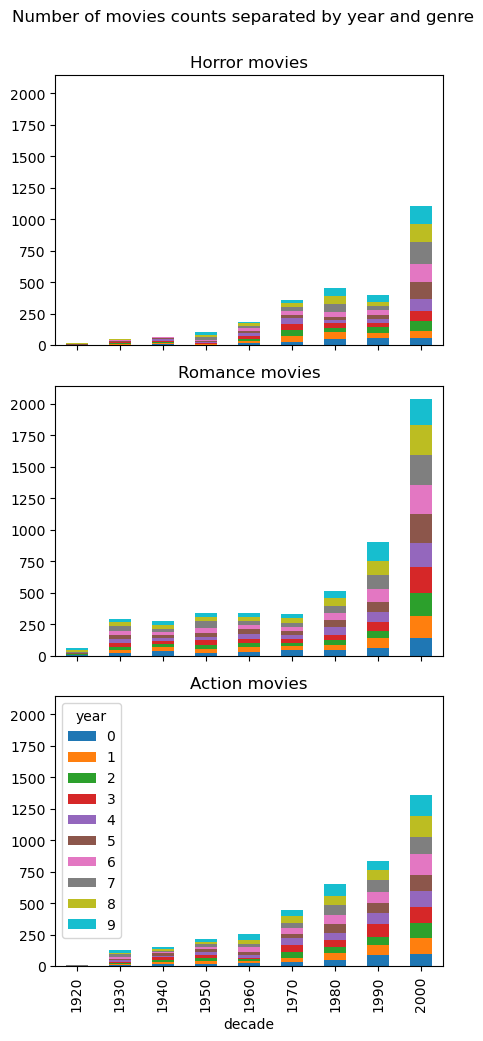

In [133]:
#Subplot the evolution of the movie per decade for each genre with the detailed count per year
fig = plt.figure(figsize=(5, 11))
gs = fig.add_gridspec(3, hspace=0.15)
axs = gs.subplots(sharex=True, sharey=True)

horror.groupby(['decade', 'year'])['release'].count().unstack().plot.bar(ax = axs[0], stacked=True)
romance.groupby(['decade', 'year'])['release'].count().unstack().plot.bar(ax = axs[1], stacked=True)
action.groupby(['decade', 'year'])['release'].count().unstack().plot.bar(ax = axs[2], stacked=True)

axs[0].get_legend().remove()
axs[1].get_legend().remove()

axs[0].title.set_text('Horror movies')
axs[1].title.set_text('Romance movies')
axs[2].title.set_text('Action movies')

fig.suptitle('Number of movies counts separated by year and genre')
fig.subplots_adjust(top=0.92)

### Character data analysis

In [134]:
#Select characters according to movies belonging to one of the three genres
horror_charadata = charadata_filtered.loc[horror.index.intersection(charadata_filtered.index)]
action_charadata = charadata_filtered.loc[action.index.intersection(charadata_filtered.index)]
romance_charadata = charadata_filtered.loc[romance.index.intersection(charadata_filtered.index)]
horror_charadata.head()

,release,character_name,actor_gender,actor_name,actor_age,decade
wiki_id,,,,,,
1952976,2005,Mediator,F,Linda Emond,46.0,2000
1952976,2005,Dahlia,F,Jennifer Connelly,34.0,2000
1952976,2005,Mr. Murray,M,John C. Reilly,40.0,2000
1952976,2005,Jeff Platzer,M,Tim Roth,44.0,2000
1952976,2005,Kyle Williams,M,Dougray Scott,39.0,2000


In [135]:
#Function which analyses character information such as age and gender and compare men and women characteristics
def count_chara(genre_data,character_genre):
    character_genre = character_genre.groupby('wiki_id')
    nb_characters = character_genre['actor_gender'].count()
    genre_data['nb_characters'] = nb_characters
    genre_data['nb_women'] = character_genre['actor_gender'].apply(lambda x: x[x == 'F'].count())
    genre_data['nb_men'] = character_genre['actor_gender'].apply(lambda x: x[x == 'M'].count())
    genre_data['ratio_gender'] = genre_data['nb_women'] / genre_data['nb_men']
    genre_data['average_age_men'] = character_genre.apply(lambda x: x['actor_age'].loc[x['actor_gender'] == 'M'].mean())
    genre_data['average_age_women'] = character_genre.apply(lambda x: x['actor_age'].loc[x['actor_gender'] == 'F'].mean())

In [136]:
count_chara(horror, horror_charadata)
count_chara(action, action_charadata)
count_chara(romance, romance_charadata)

In [137]:
# The function computes the means of the age of men and women actors as well as the standard deviations for each decade 

def stats_age_decade(genre_charadata):

    genre_age = genre_charadata.groupby(['decade'])
    mean_age_men = genre_age.apply(lambda x : x.loc[x['actor_gender'] == 'M']['actor_age'].mean())
    std_age_men = genre_age.apply(lambda x : x.loc[x['actor_gender'] == 'M']['actor_age'].std())
    mean_age_women = genre_age.apply(lambda x : x.loc[x['actor_gender'] == 'F']['actor_age'].mean())
    std_age_women = genre_age.apply(lambda x : x.loc[x['actor_gender'] == 'F']['actor_age'].std())

    return mean_age_men, std_age_men, mean_age_women, std_age_women

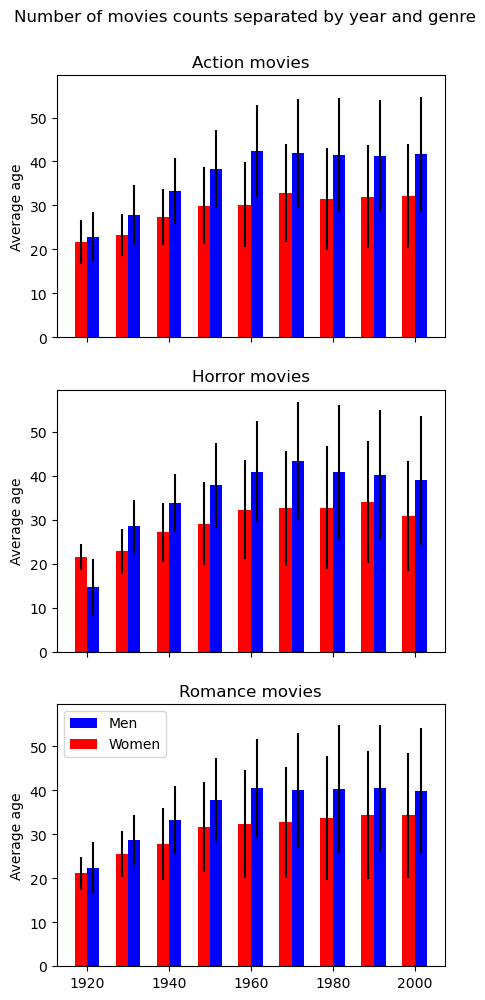

In [138]:
# Compute some stats for the three selected genres and plot them by decade for each genre
action_age = stats_age_decade(action_charadata)
horror_age = stats_age_decade(horror_charadata)
romance_age = stats_age_decade(romance_charadata)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,figsize=(5, 11), sharex = True, sharey = True)
width = 3

ax0.bar(action_age[0].index + width/2, action_age[0],width, yerr = action_age[1],label='Men', color = 'blue')
ax0.bar(action_age[2].index - width/2, action_age[2],width, yerr = action_age[3],  label='Women', color = 'red')
ax1.bar(horror_age[0].index + width/2, horror_age[0],width, yerr = horror_age[1],label='Men', color = 'blue')
ax1.bar(horror_age[2].index - width/2, horror_age[2],width, yerr = horror_age[3],  label='Women', color = 'red')
ax2.bar(romance_age[0].index + width/2, romance_age[0],width, yerr = romance_age[1],label='Men', color = 'blue')
ax2.bar(romance_age[2].index - width/2, romance_age[2],width, yerr = romance_age[3],  label='Women', color = 'red')


ax0.set_title('Action movies')
ax1.set_title('Horror movies')
ax2.set_title('Romance movies')

ax0.set_ylabel('Average age')
ax1.set_ylabel('Average age')
ax2.set_ylabel('Average age')

ax2.legend(loc='upper left')

fig.suptitle('Number of movies counts separated by year and genre')
fig.subplots_adjust(top=0.92)

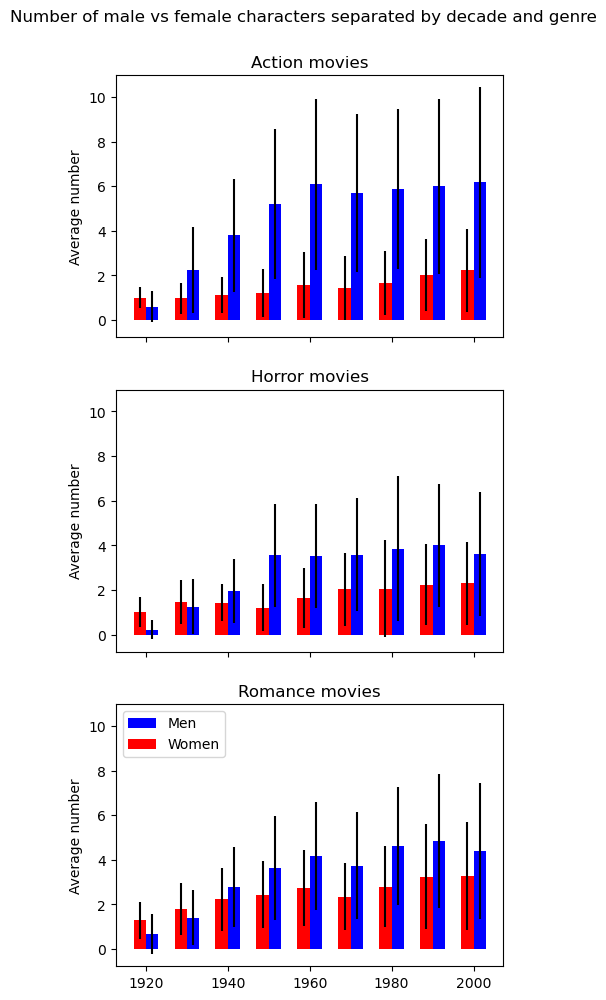

In [139]:
#Plot the average number of men vs women for each genre over time

width = 3
action_nb_men = action.groupby(['decade'])['nb_men']
action_nb_women = action.groupby(['decade'])['nb_women']
horror_nb_men = horror.groupby(['decade'])['nb_men']
horror_nb_women = horror.groupby(['decade'])['nb_women']
romance_nb_men = romance.groupby(['decade'])['nb_men']
romance_nb_women = romance.groupby(['decade'])['nb_women']

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,figsize=(5, 11), sharex = True, sharey = True)

ax0.bar(action['decade'].sort_values().unique() + width/2, action_nb_men.mean(),width, yerr = action_nb_men.std(),label='Men', color = 'blue')
ax0.bar(action['decade'].sort_values().unique() - width/2, action_nb_women.mean(),width, yerr = action_nb_women.std(),  label='Women', color = 'red')
ax1.bar(action['decade'].sort_values().unique() + width/2, horror_nb_men.mean(),width, yerr = horror_nb_men.std(),label='Men', color = 'blue')
ax1.bar(action['decade'].sort_values().unique() - width/2, horror_nb_women.mean(),width, yerr = horror_nb_women.std(),  label='Women', color = 'red')
ax2.bar(action['decade'].sort_values().unique() + width/2, romance_nb_men.mean(),width, yerr = romance_nb_men.std(),label='Men', color = 'blue')
ax2.bar(action['decade'].sort_values().unique() - width/2, romance_nb_women.mean(),width, yerr = romance_nb_women.std(),  label='Women', color = 'red')

ax0.set_title('Action movies')
ax1.set_title('Horror movies')
ax2.set_title('Romance movies')

ax0.set_ylabel('Average number')
ax1.set_ylabel('Average number')
ax2.set_ylabel('Average number')

ax2.legend(loc='upper left')

fig.suptitle('Number of male vs female characters separated by decade and genre')
fig.subplots_adjust(top=0.92)

### Language Analysis

In [ ]:
from bs4 import BeautifulSoup
from bs4 import SoupStrainer
import gzip
import re

NLP_FOLDER = 'CoreNLP/corenlp_plot_summaries/'

In [61]:
#select only caharacters for which we have both the gender and the charcter name to allow langage analysis
charadata_2 = charadata_filtered[charadata_filtered["character_name"].notna()]  
intersection = moviedata_filtered.index.intersection(charadata_2.index)
intersection = plots.index.intersection(intersection)

charadata_2 = charadata_2.reset_index()
movie_2 = moviedata_filtered.loc[intersection]
movie_2 = movie_2.reset_index()

# select 1000 random movies per decade from 1940 to process a langage analysis on the plots
rng = np.random.default_rng(7)

movie_2['release'] = pd.to_datetime(movie_2['release'], errors = 'coerce')
movie_2['release'] = pd.DatetimeIndex(movie_2['release']).year
movie_2 = movie_2[movie_2['release'].notna()]
movie_2['release'] = movie_2['release'].astype(int)
movie_2['decade'] = (movie_2['release']//10)*10

decades = np.arange(1940,2001,10)
sample = []
for decade in decades:
    char_movie = charadata_2[charadata_2['decade'] == decade]
    sample = np.append(sample, rng.choice(char_movie.wiki_id.unique(), size=500, replace = False))


movie_2 = movie_2[movie_2["wiki_id"].isin(sample)]
charadata_2 = charadata_2[charadata_2["wiki_id"].isin(sample)]

charadata_2 = charadata_2.set_index('wiki_id')
movie_2 = movie_2.set_index('wiki_id')

movie_2 = movie_2.assign(agent_woman = lambda x : 0)
movie_2 = movie_2.assign(patient_woman = lambda x : 0)
movie_2 = movie_2.assign(attributes_woman = lambda x : 0)
movie_2 = movie_2.assign(agent_man = lambda x : 0)
movie_2 = movie_2.assign(patient_man = lambda x : 0)
movie_2 = movie_2.assign(attributes_man = lambda x : 0)


charadata_2 = charadata_2.assign(agent = lambda x : 0)
charadata_2 = charadata_2.assign(patient = lambda x : 0)
charadata_2 = charadata_2.assign(attributes = lambda x : 0)

In [62]:
# The function returns a list of the text found by the CoreNLP parser 
# for either the governor or dependent element of agent and patient verbs and attributes
# Input : BeautifulSoup element on which to perform the extraction, the list of types of elements to search, 
#         string to indicate either to search for governor or dependent element of the tuples extracted by the pipeline 

def extract_dep_gov(soup, list, type):

    list_valid_type = ('governor', 'dependent')
    if type not in list_valid_type:
        raise ValueError("Wrong syntactic type, either: governor, dependent")

    role_type = []

    # get the text for one element of the tuples extracted by the parser depending of the list of elements extract

    if "prep_" in list:
        role_type += [a.find(type).get_text() for a in soup.find_all('dep', type = lambda value: value and value.startswith('prep_'))]
        list.remove('prep_')    
    role_type += [[a.find(type).get_text() for a in soup.find_all('dep', {'type': str(ele)})] for ele in list]
    role_type = [re.sub(r"[^a-zA-Z0-9]","",str(i)) for i in role_type]  # filter out non alphabetical or numerical characters found

    return role_type

#######

# The function counts the number of time a male or female character has been mentioned in the plot 
# Input: takes list to find character's name occurences from tuple produced by CoreNLP parser, the wiki_id of the movie,
#        dataframes of the movies' data and the characters' data,and string for the role type (i.e. agent, patient, attributes)

def count_chara_NLP(list_name_parser, movie_id, movie_data, character_data, charadata_2, type):

    list_valid_type = ("patient", "agent", "attributes")
    if type not in list_valid_type:
        raise ValueError("Wrong role type, either: patient, agent, attributes")
        
    # For every element extracted from the tuples of the CoreNLP pipeline, add count in the data of the corresponding movie
    for elem in list_name_parser:
        for index, chara in enumerate(character_data['character_name']):
            name_split = chara.split()
            for name_sep in name_split:
                if elem == name_sep: # if name_sep.casefold() in map(str.casefold, list_name_parser):
                    # Count number of words associated to women or men depending of the role type analyzed
                    charadata_2.loc[charadata_2['character_name'] == chara, type] += 1
                    # gender = ''.join(character_data.iloc[index]['actor_gender'].split())
                    if ('M' in character_data.iloc[index]['actor_gender']):
                        movie_data.loc[movie_id, str(type + '_man')] += 1
                    elif ('F' in character_data.iloc[index]['actor_gender']):
                        movie_data.loc[movie_id, str(type + '_woman')] += 1

In [64]:
for movie_id in movie_2.index :
    with gzip.open(NLP_FOLDER + str(movie_id) +'.xml.gz', 'r') as f:
        data = f.read()
    cc_processed = SoupStrainer("collapsed-ccprocessed-dependencies")
    soup = BeautifulSoup(data, "xml", parse_only=cc_processed)
   

    agent_dependent = [a.find('dependent').get_text() for a in soup.find_all('dep',{'type':'nsubj'})]
    agent_dependent += [a.find('dependent').get_text() for a in soup.find_all('dep',{'type':'agent'})]
    agent_dependent = [re.sub(r"[^a-zA-Z0-9]","",i) for i in agent_dependent]


    patient_dependent = [a.find('dependent').get_text() for a in soup.find_all('dep',{'type':'dobj'})]
    patient_dependent += [a.find('dependent').get_text() for a in soup.find_all('dep',{'type':'nsubjpass'})]
    patient_dependent += [a.find('dependent').get_text() for a in soup.find_all('dep',{'type':'iobj'})]
    patient_dependent += [a.find('dependent').get_text() for a in soup.find_all('dep', type = lambda value: value and value.startswith('prep_'))]
    patient_dependent = [re.sub(r"[^a-zA-Z0-9]","",i) for i in patient_dependent]

    attributes_dependent = [a.find('governor').get_text() for a in soup.find_all('dep',{'type':'nsubj'})]
    attributes_dependent += [a.find('governor').get_text() for a in soup.find_all('dep',{'type':'appos'})]
    attributes_dependent += [a.find('dependent').get_text() for a in soup.find_all('dep',{'type':'nsubj'})]
    attributes_dependent += [a.find('dependent').get_text() for a in soup.find_all('dep',{'type':'appos'})]
    attributes_dependent += [a.find('dependent').get_text() for a in soup.find_all('dep',{'type':'amod'})]
    attributes_dependent += [a.find('dependent').get_text() for a in soup.find_all('dep',{'type':'nn'})]
    attributes_dependent = [re.sub(r"[^a-zA-Z0-9]","",i) for i in attributes_dependent]

    movie_chara = charadata_2[charadata_2.index == movie_id][['character_name','actor_gender']].reset_index().copy()
    movie_chara = movie_chara[~movie_chara.isnull().any(axis=1)]

    count_chara_NLP(agent_dependent, movie_id, movie_2, movie_chara, charadata_2, "agent")
    count_chara_NLP(patient_dependent, movie_id, movie_2, movie_chara, charadata_2, "patient")
    count_chara_NLP(attributes_dependent, movie_id, movie_2, movie_chara, charadata_2, "attributes")

In [66]:
#convert to csv
movie_2.to_csv('movie_langage_data.csv')

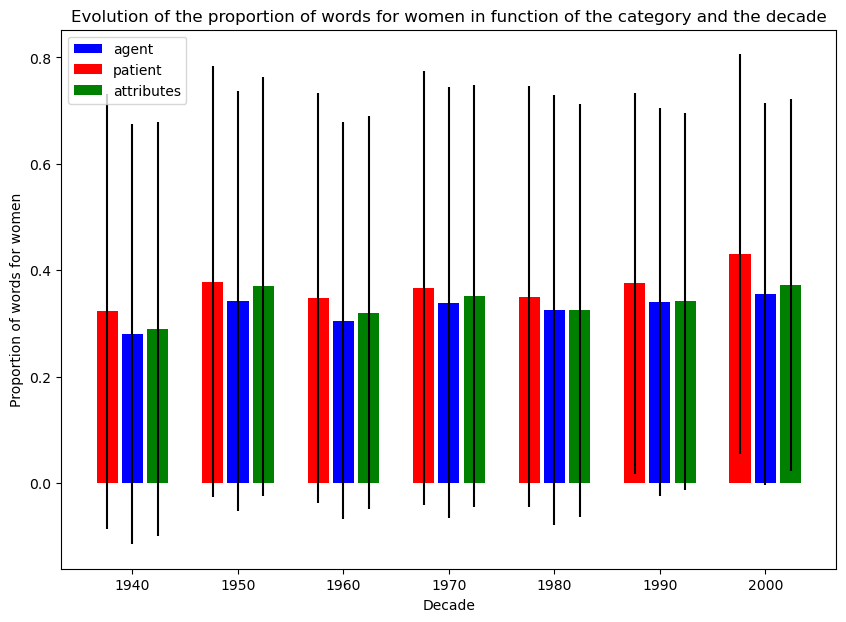

In [69]:
width = 3

movie_2_grp = movie_2.groupby(['decade'])
agent_mean = movie_2_grp.apply(lambda x : (x['agent_woman']/(x['agent_man'] + x['agent_woman'])).mean())
agent_std = movie_2_grp.apply(lambda x : (x['agent_woman']/(x['agent_man'] + x['agent_woman'])).std())
patient_mean = movie_2_grp.apply(lambda x : (x['patient_woman']/(x['patient_man'] + x['patient_woman'])).mean())
patient_std = movie_2_grp.apply(lambda x : (x['patient_woman']/(x['patient_man'] + x['patient_woman'])).std())
attributes_mean = movie_2_grp.apply(lambda x : (x['attributes_woman']/(x['attributes_man'] + x['attributes_woman'])).mean())
attributes_std = movie_2_grp.apply(lambda x : (x['attributes_woman']/(x['attributes_man'] + x['attributes_woman'])).std())

plt.figure(figsize=(10, 7))

plt.bar(agent_mean.index, agent_mean,width/1.5, yerr = agent_std,label='agent', color = 'blue')
plt.bar(patient_mean.index - width/1.25, patient_mean,width/1.5, yerr = patient_std,  label='patient', color = 'red')
plt.bar(attributes_mean.index + width/1.25, attributes_mean,width/1.5, yerr = attributes_std,  label='attributes', color = 'green')


plt.legend(loc = 'upper left')
plt.title('Evolution of the proportion of words for women in function of the category and the decade')
plt.xlabel('Decade')
plt.ylabel('Proportion of words for women')
plt.show()

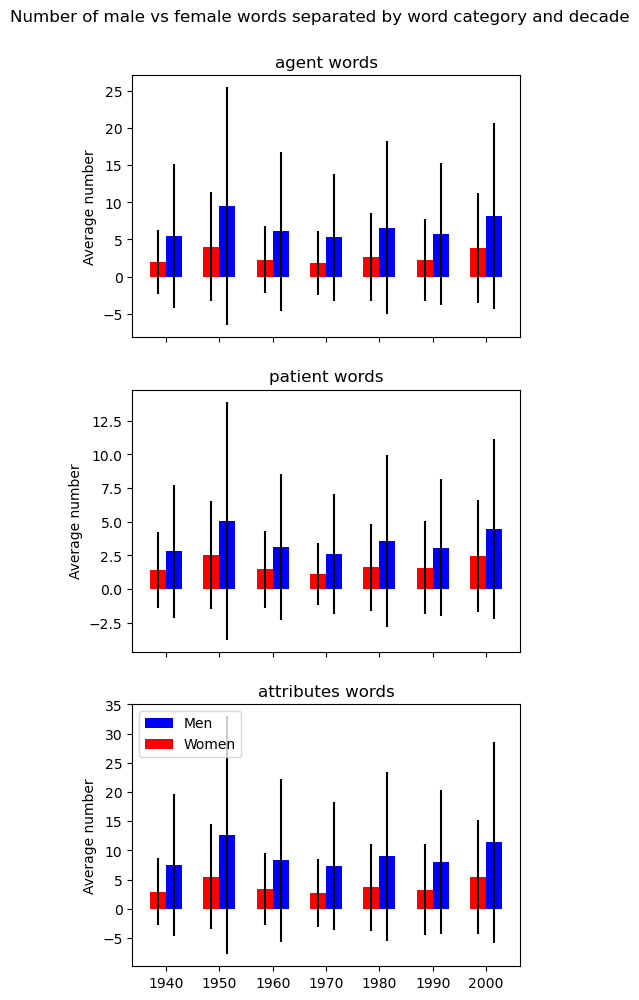

In [68]:
#Plot the average number of men vs women for each genre separated by decade
width = 3
movie_2_grp = movie_2.groupby(['decade'])
agent_nb_men = movie_2_grp['agent_man']
agent_nb_women = movie_2_grp['agent_woman']
patient_nb_men = movie_2_grp['patient_man']
patient_nb_women = movie_2_grp['patient_woman']
attributes_nb_men = movie_2_grp['attributes_man']
attributes_nb_women = movie_2_grp['attributes_woman']

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,figsize=(5, 11), sharex = True, sharey = False)

ax0.bar(movie_2['decade'].unique() + width/2, agent_nb_men.mean(),width, yerr = agent_nb_men.std(),label='Men', color = 'blue')
ax0.bar(movie_2['decade'].unique() - width/2, agent_nb_women.mean(),width, yerr = agent_nb_women.std(),  label='Women', color = 'red')
ax1.bar(movie_2['decade'].unique() + width/2, patient_nb_men.mean(),width, yerr = patient_nb_men.std(),label='Men', color = 'blue')
ax1.bar(movie_2['decade'].unique() - width/2, patient_nb_women.mean(),width, yerr = patient_nb_women.std(),  label='Women', color = 'red')
ax2.bar(movie_2['decade'].unique() + width/2, attributes_nb_men.mean(),width, yerr = attributes_nb_men.std(),label='Men', color = 'blue')
ax2.bar(movie_2['decade'].unique() - width/2, attributes_nb_women.mean(),width, yerr = attributes_nb_women.std(),  label='Women', color = 'red')

ax0.set_title('Agent verbs')
ax1.set_title('Patient vers')
ax2.set_title('Attributes')

ax0.set_ylabel('Average number')
ax1.set_ylabel('Average number')
ax2.set_ylabel('Average number')

ax2.legend(loc='upper left')

fig.suptitle('Number of male vs female words separated by word category and decade')
fig.subplots_adjust(top=0.92)

In [ ]:
"""import scipy.stats
doi = 2000
print(scipy.stats.ttest_ind(movie_2.loc[movie_2['decade'] == doi]['agent_woman'],movie_2.loc[movie_2['decade'] == doi]['agent_man'],alternative='less'))
print(scipy.stats.ttest_ind(movie_2.loc[movie_2['decade'] == doi]['patient_woman'],movie_2.loc[movie_2['decade'] == doi]['patient_man'],alternative='less'))
print(scipy.stats.ttest_ind(movie_2.loc[movie_2['decade'] == doi]['attributes_woman'],movie_2.loc[movie_2['decade'] == doi]['attributes_man'],alternative = 'less'))
"""

"import scipy.stats\ndoi = 2000\nprint(scipy.stats.ttest_ind(movie_2.loc[movie_2['decade'] == doi]['agent_woman'],movie_2.loc[movie_2['decade'] == doi]['agent_man'],alternative='less'))\nprint(scipy.stats.ttest_ind(movie_2.loc[movie_2['decade'] == doi]['patient_woman'],movie_2.loc[movie_2['decade'] == doi]['patient_man'],alternative='less'))\nprint(scipy.stats.ttest_ind(movie_2.loc[movie_2['decade'] == doi]['attributes_woman'],movie_2.loc[movie_2['decade'] == doi]['attributes_man'],alternative = 'less'))\n"